El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_3725848/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "HUWA-DAO"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "3d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = None


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 4151 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4151 entries, 0 to 4150
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       4151 non-null   object        
 1   name           4151 non-null   object        
 2   id             4151 non-null   object        
 3   proposal       4151 non-null   category      
 4   deployment     4151 non-null   object        
 5   platform_vote  4151 non-null   object        
 6   voter          4151 non-null   category      
 7   date           4151 non-null   datetime64[ns]
 8   choice         4151 non-null   object        
 9   weight         4151 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 322.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 572 entries, 0 to 571
Data columns (total 13 columns):
 #   Column               Non-Null Coun

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x4254c53fc3b3b38df025ea30bcae410e11bb95b6,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-07 09:41:01,1
1,0xa2c99645039842faac58f29c54a0e0d528dd9273,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-07 05:05:39,1
2,0xf7a3a1ddcd7c6bf710048f261eb47807d5c168a1,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-06 09:03:33,1
3,0x7bb4860dcaeec291b56a7e3f74f299628e3bb239,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-05 08:55:35,1
4,0xc24fe6f2bae027aeee47390be73d121f18f51bdb,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-05 01:46:00,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                           572
mean      8 days 13:12:18.222027972
std      12 days 04:45:24.465762690
min                 0 days 06:00:00
25%                 2 days 00:00:00
50%                 3 days 00:00:00
75%                 9 days 00:00:00
max               105 days 02:00:00
dtype: object

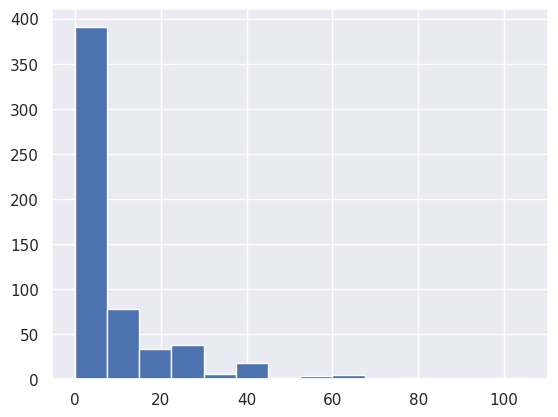

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

In [7]:
delta.value_counts()

2 days 00:00:00     158
1 days 00:00:00      79
8 days 00:00:00      28
7 days 00:00:00      24
3 days 00:00:00      22
                   ... 
25 days 18:00:00      1
2 days 02:00:00       1
5 days 15:00:00       1
4 days 23:59:59       1
16 days 19:46:00      1
Length: 152, dtype: int64

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

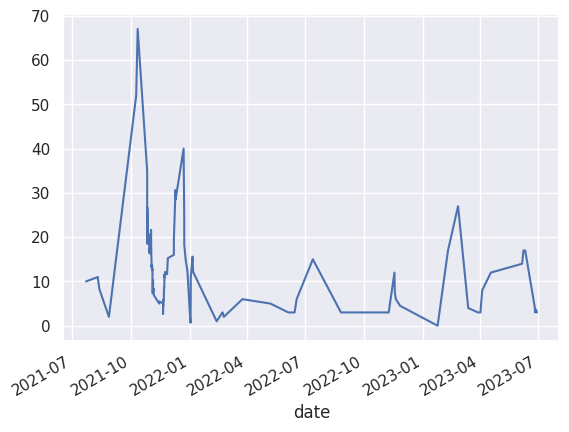

In [8]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Friday       159
Thursday     117
Wednesday     89
Monday        71
Saturday      64
Tuesday       42
Sunday        30
Name: start, dtype: int64

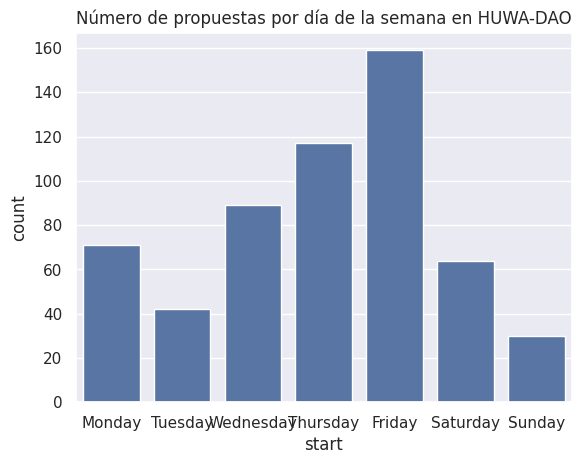

In [9]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Text(0, 0.5, '')

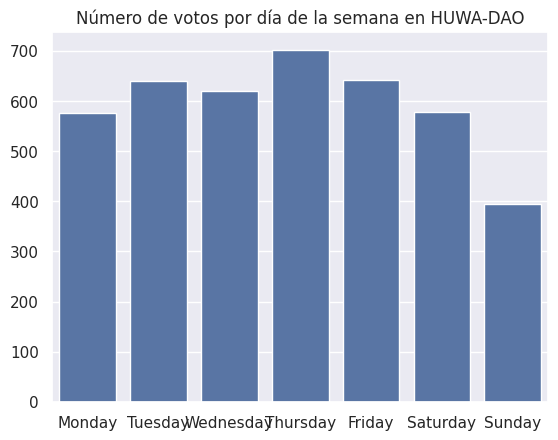

In [10]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()
plt.xlabel('')
plt.ylabel('')

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

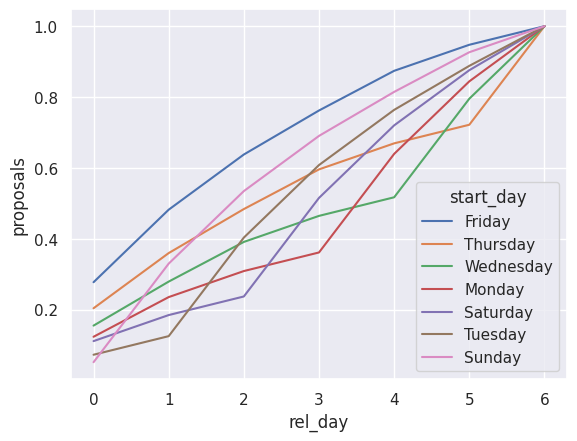

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

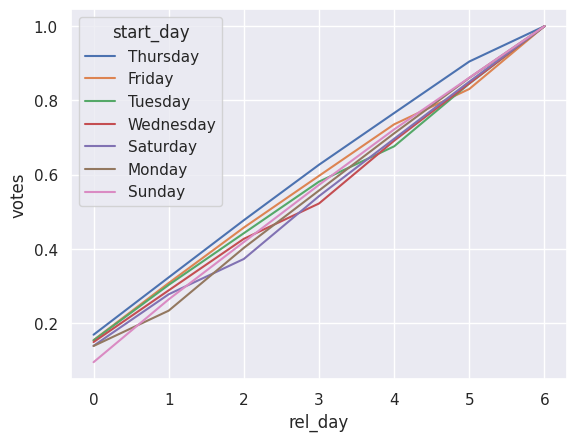

In [12]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

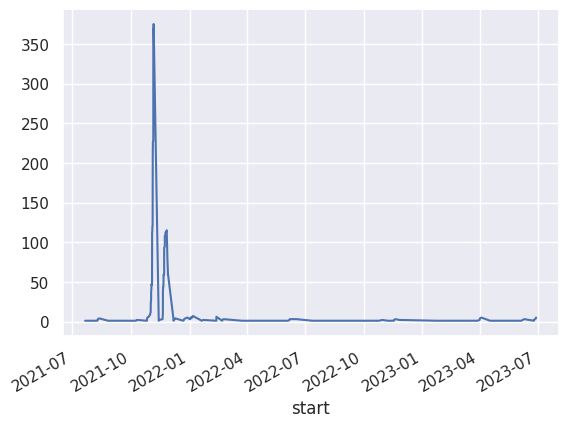

In [13]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [14]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                           W-SUN       W-MON       W-TUE  \
votes in open proposals (train) count  100.000000  100.000000  100.000000   
                                mean    52.050000   53.030000   54.590000   
                                std    143.156718  145.449110  149.467208   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    977.000000  984.000000  983.000000   
users in open proposals (train) count  100.000000  100.000000  100.000000   
                                mean    31.390000   32.460000   33.500000   
                                std     76.618153   79.679968   82.357253   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    469.000000  471.000000  474.000000   
open proposals                  count  100.000000  100.000000  100.000000   
                                mean     6.890000    6.520000    6.870000   
                                std     24.577190   22.369929   23.173328   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    167.000000  126.000000  133.000000   
votes in test                   count  100.000000  100.000000  100.000000   
                                mean     8.680000    7.930000    7.040000   
                                std     24.582937   18.415110   15.037945   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    198.000000  110.000000  105.000000   
users in test                   count  100.000000  100.000000  100.000000   
                                mean     6.260000    5.580000    4.790000   
                                std     18.422439   11.839994    9.161067   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    162.000000   67.000000   63.000000   
vpp test                        count   44.000000   45.000000   47.000000   
                                mean     4.609878    4.409233    4.113709   
                                std      5.194920    4.580636    4.166946   
                                min      0.000000    0.000000    0.000000   
                                50%      2.166667    3.000000    3.666667   
                                max     19.000000   17.000000   16.000000   
vpu test                        count   37.000000   38.000000   41.000000   
                                mean     1.306702    1.301330    1.462539   
                                std      0.382668    0.380637    1.120842   
                                min      1.000000    1.000000    1.000000   
                                50%      1.066667    1.000000    1.111111   
                                max      2.307692    2.333333    8.000000   

f                                           W-WED       W-THU        W-SAT  
votes in open proposals (train) count  100.000000  100.000000   101.000000  
                                mean    51.080000   54.480000    54.623762  
                                std    130.806950  139.137929   159.102913  
                                min      0.000000    0.000000     0.000000  
                                50%      1.000000    1.000000     0.000000  
                                max    861.000000  925.000000  1046.000000  
users in open proposals (train) count  100.000000  100.000000   101.000000  
                                mean    32.140000   33.250000    33.4554

In [15]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_3725848/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),5205.000000,5303.000000,5459.000000,5108.000000,5448.000000,5517.000000
users in open proposals (train),3139.000000,3246.000000,3350.000000,3214.000000,3325.000000,3379.000000
open proposals,689.000000,652.000000,687.000000,621.000000,679.000000,785.000000
votes in test,868.000000,793.000000,704.000000,761.000000,772.000000,830.000000
users in test,626.000000,558.000000,479.000000,510.000000,466.000000,577.000000
vpp test,202.834616,198.415468,193.344336,217.990701,185.676466,158.203244
vpu test,48.347966,49.450531,59.964088,61.943953,57.104254,44.611576


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [16]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [17]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [18]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [19]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-08-27 09:01:56)  =====
Currently open proposals: 1
Train votes in open proposals:   1
Test votes in open proposals:    0

===== Training on fold 1 (t: 2021-11-28 05:17:39)  =====
Currently open proposals: 126
Train votes in open proposals: 980
Test votes in open proposals:  113

===== Training on fold 2 (t: 2022-01-28 23:17:46)  =====
Currently open proposals: 5
Train votes in open proposals: 168
Test votes in open proposals:    0



===== Training on fold 3 (t: 2022-03-30 08:53:21)  =====
Currently open proposals: 1
Train votes in open proposals:  36
Test votes in open proposals:    0

===== Training on fold 4 (t: 2022-06-08 06:37:55)  =====
Currently open proposals: 2
Train votes in open proposals:  26
Test votes in open proposals:    2



===== Training on fold 5 (t: 2022-07-27 13:26:36)  =====
Currently open proposals: 1
Train votes in open proposals:  18
Test votes in open proposals:    0

===== Training on fold 6 (t: 2022-08-28 05:32:00)  =====
Currently open proposals: 1
Train votes in open proposals:  10
Test votes in open proposals:    0

===== Training on fold 7 (t: 2022-12-01 14:09:58)  =====
Currently open proposals: 1
Train votes in open proposals:   5
Test votes in open proposals:    0

===== Training on fold 8 (t: 2023-02-21 22:34:51)  =====
Currently open proposals: 1
Train votes in open proposals:  21
Test votes in open proposals:    6



===== Training on fold 9 (t: 2023-04-26 04:50:33)  =====
Currently open proposals: 2
Train votes in open proposals:  67
Test votes in open proposals:    1



In [20]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.061194,0.302900,0.302488,0.302985,0.030597,0.302900,0.302488,0.302985,0.020597,0.303247,0.302560,0.303856,0.092836,0.046866
std,0.095856,0.481128,0.481391,0.481074,0.047928,0.481128,0.481391,0.481074,0.031844,0.480910,0.481344,0.480533,0.125448,0.063667
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.152985,0.757251,0.756219,0.757463,0.076493,0.757251,0.756219,0.757463,0.051493,0.758118,0.756400,0.759639,0.200000,0.100000
max,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000,0.328358,0.168657


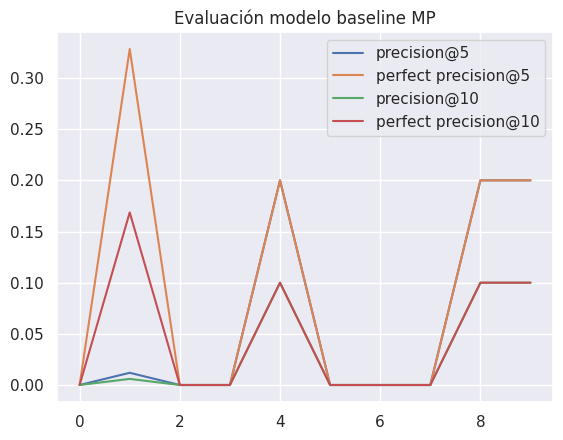

In [21]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.092836,0.400000,0.399325,0.399325,0.046866,0.400000,0.400000,0.400000,0.031244,0.400000,0.400000,0.400000
std,0.125448,0.516398,0.515530,0.515530,0.063667,0.516398,0.516398,0.516398,0.042445,0.516398,0.516398,0.516398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.200000,1.000000,0.998312,0.998312,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000
max,0.328358,1.000000,1.000000,1.000000,0.168657,1.000000,1.000000,1.000000,0.112438,1.000000,1.000000,1.000000


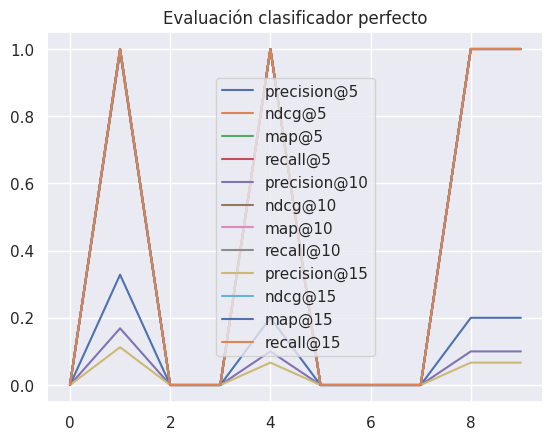

In [22]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [23]:
from tqdm.autonotebook import tqdm

In [24]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/235 [00:00<?, ?it/s]

Warning, empty test fold 0
Warning, empty test fold 1
Warning, empty test fold 2
Warning, empty test fold 3
Warning, empty test fold 4
Warning, empty test fold 5
Warning, empty test fold 6


Warning, empty test fold 7
Warning, empty test fold 8
Warning, empty test fold 9
Warning, empty test fold 10
Warning, empty test fold 11
Warning, empty test fold 12


Warning, empty test fold 13
Warning, empty test fold 14
Warning, empty test fold 15
Warning, empty test fold 16
Warning, empty test fold 17
Warning, empty test fold 18


Warning, empty test fold 19
Warning, empty test fold 20
Warning, empty test fold 21
Warning, empty test fold 22
Warning, empty test fold 23
Warning, empty test fold 24


Warning, empty test fold 25


Warning, empty test fold 63
Warning, empty test fold 64
Warning, empty test fold 65


Warning, empty test fold 66
Warning, empty test fold 67
Warning, empty test fold 68
Warning, empty test fold 69
Warning, empty test fold 70


Warning, empty test fold 72
Warning, empty test fold 73
Warning, empty test fold 74
Warning, empty test fold 75
Warning, empty test fold 76


Warning, empty test fold 77
Warning, empty test fold 78
Warning, empty test fold 79
Warning, empty test fold 80


Warning, empty test fold 83
Warning, empty test fold 84
Warning, empty test fold 85


Warning, empty test fold 86
Warning, empty test fold 87
Warning, empty test fold 88
Warning, empty test fold 89
Warning, empty test fold 90


Warning, empty test fold 91
Warning, empty test fold 92
Warning, empty test fold 93
Warning, empty test fold 94
Warning, empty test fold 95


Warning, empty test fold 98
Warning, empty test fold 99
Warning, empty test fold 100
Warning, empty test fold 101
Warning, empty test fold 102


Warning, empty test fold 103
Warning, empty test fold 104


Warning, empty test fold 107


Warning, empty test fold 112
Warning, empty test fold 113
Warning, empty test fold 114
Warning, empty test fold 115
Warning, empty test fold 116


Warning, empty test fold 117


Warning, empty test fold 123
Warning, empty test fold 124
Warning, empty test fold 125
Warning, empty test fold 126
Warning, empty test fold 127


Warning, empty test fold 128
Warning, empty test fold 129
Warning, empty test fold 130


Warning, empty test fold 131
Warning, empty test fold 132
Warning, empty test fold 134


Warning, empty test fold 135
Warning, empty test fold 136
Warning, empty test fold 137
Warning, empty test fold 138
Warning, empty test fold 139


Warning, empty test fold 140
Warning, empty test fold 141
Warning, empty test fold 142
Warning, empty test fold 143
Warning, empty test fold 144


Warning, empty test fold 145
Warning, empty test fold 146
Warning, empty test fold 147
Warning, empty test fold 148
Warning, empty test fold 149


Warning, empty test fold 150
Warning, empty test fold 151
Warning, empty test fold 152


Warning, empty test fold 154
Warning, empty test fold 156


Warning, empty test fold 157
Warning, empty test fold 159
Warning, empty test fold 160


Warning, empty test fold 165
Warning, empty test fold 166
Warning, empty test fold 167
Warning, empty test fold 168
Warning, empty test fold 169


Warning, empty test fold 170
Warning, empty test fold 171
Warning, empty test fold 172


Warning, empty test fold 173
Warning, empty test fold 174
Warning, empty test fold 175
Warning, empty test fold 176
Warning, empty test fold 177


Warning, empty test fold 178
Warning, empty test fold 179
Warning, empty test fold 180
Warning, empty test fold 181
Warning, empty test fold 182


Warning, empty test fold 184
Warning, empty test fold 185
Warning, empty test fold 186
Warning, empty test fold 187
Warning, empty test fold 188


Warning, empty test fold 203
Warning, empty test fold 205


Warning, empty test fold 215
Warning, empty test fold 216
Warning, empty test fold 217
Warning, empty test fold 218
Warning, empty test fold 219


Warning, empty test fold 220
Warning, empty test fold 221
Warning, empty test fold 222
Warning, empty test fold 223
Warning, empty test fold 224


Warning, empty test fold 225
Warning, empty test fold 226


In [25]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2021-07-22 11:44:39 2023-07-01 00:51:20


t0: 2021-07-25 00:00:00
t1: 2021-07-28 00:00:00
t-2: 2023-06-24 00:00:00
t-1: 2023-06-27 00:00:00


In [26]:
{ k:len(v) for k,v in metrics.items() }

{'t': 235,
 'precision@5': 235,
 'ndcg@5': 235,
 'map@5': 235,
 'recall@5': 235,
 'precision@10': 235,
 'ndcg@10': 235,
 'map@10': 235,
 'recall@10': 235,
 'precision@15': 235,
 'ndcg@15': 235,
 'map@15': 235,
 'recall@15': 235}

In [27]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2021-07-22 11:44:27')

Timestamp('2021-07-22 11:44:39')

,userID,itemID,timestamp,rating
1512,0x7452e7d530078dbd6a2ed65007bea00a4d60f138,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:44:39,1
1511,0x2245be89fc8fab94ed982e859aa3212a4e4eb7e5,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:48:19,1
1510,0x5f527da3f5d3107423080165ed5452c94940c812,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:48:38,1
1509,0xd903839f391b169becc0a9d5aa98e26a06542cd0,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:53:23,1
1508,0xab7b49bacd43bd4cfa41433d477f690bb9e1fb26,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:57:02,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
207,snapshot,HUWA-DAO,huwacoin.eth,7f78eca6-a122-5074-ad86-268642177a4b,7b930871-5e1b-5efe-af9a-dc5413460604,QmNxdVzvC2o2Rz1r492SwHHgy9TJnu6GpgZ8i3SQu6oXYx,0x7452e7d530078dbd6a2ed65007bea00a4d60f138,2021-07-22 11:44:27,瓜分派派的七千大饼,同意还是不同意,2021-07-21 04:00:00,2021-07-31 04:00:00,13
302,snapshot,HUWA-DAO,huwacoin.eth,77a00336-c958-5fb9-b28b-88927a594d31,7b930871-5e1b-5efe-af9a-dc5413460604,QmfPpBkVnYi1e2wEYFqi3LbXcAF1bjAbHAGHjERDM6Qpwf,0x0aa5973f2614dccfbe53c8273da22502d7e4fbd5,2021-08-10 02:11:43,我没什么建议，感觉投票项目还没发币，我要发起一个提案布局一下,万一呢,2021-08-10 02:00:00,2021-08-21 04:00:00,26
349,snapshot,HUWA-DAO,huwacoin.eth,5f965ce6-792e-5700-83b1-5f2122281a85,7b930871-5e1b-5efe-af9a-dc5413460604,QmWN8HReKkuER1zRxMUT65FdXLsrmYoRRWjKdwP9nLb3FX,0x2245be89fc8fab94ed982e859aa3212a4e4eb7e5,2021-08-10 02:17:04,是否要准备HUWA3.0，防止2.0被燃烧,,2021-08-09 04:00:00,2021-08-20 04:00:00,11
67,snapshot,HUWA-DAO,huwacoin.eth,85b9f980-6029-5e04-a0b2-58bb466024e4,7b930871-5e1b-5efe-af9a-dc5413460604,QmcpWN2Un7XgzFAjXBWyS5aVWfoXnTqV9gkUX3hDkDqM4y,0xf23a9799fe0011acb4326306a539b88644ac19a2,2021-08-10 02:27:20,看了地主的建议，我也要来发个提案布局一下，感谢老哥的新Space!,,2021-08-10 00:00:00,2021-08-20 04:00:00,16
74,snapshot,HUWA-DAO,huwacoin.eth,02257bb0-82db-5edc-b9c5-d70a79309d8d,7b930871-5e1b-5efe-af9a-dc5413460604,Qmbc4oXkWdbXn73iWLAbDxK9VRTR9hJZ7FS1hHKnkLvvpJ,0x2245be89fc8fab94ed982e859aa3212a4e4eb7e5,2021-08-12 11:59:37,做snapshot任务,没建议,2021-08-12 04:00:00,2021-08-13 04:00:00,10


In [28]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,0.080597,0.295137,0.279359,0.333920,0.044289,0.304721,0.284486,0.359739,0.030006,0.305480,0.284836,0.361886,0.100318,0.050864,0.391136
std,0.112232,0.422089,0.415103,0.456808,0.060236,0.422250,0.414071,0.473478,0.040603,0.422321,0.414031,0.475082,0.136820,0.071482,0.488705
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.200000,0.738305,0.649808,1.000000,0.100000,0.738305,0.649808,1.000000,0.066667,0.738305,0.649808,1.000000,0.200000,0.100000,1.000000
max,0.463158,1.000000,1.000000,1.000000,0.231579,1.000000,1.000000,1.000000,0.154386,1.000000,1.000000,1.000000,0.672727,0.463636,1.000000


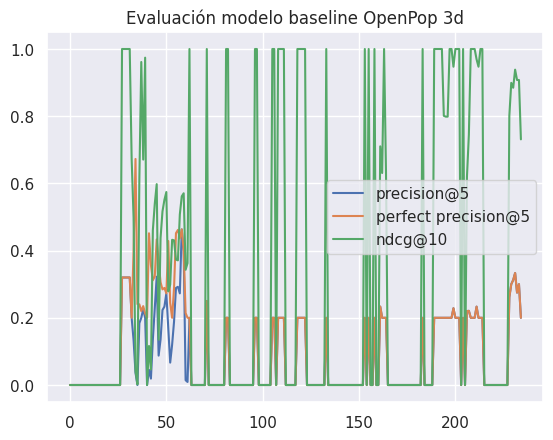

In [29]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [30]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.198237,0.607038,0.574927,0.700000,0.099119,0.607038,0.574927,0.700000,0.066079,0.607038,0.574927,0.700000,0.198237,0.099119,0.700000
std,0.141349,0.423192,0.404590,0.483046,0.070674,0.423192,0.404590,0.483046,0.047116,0.423192,0.404590,0.483046,0.141349,0.070674,0.483046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050000,0.182786,0.161111,0.250000,0.025000,0.182786,0.161111,0.250000,0.016667,0.182786,0.161111,0.250000,0.050000,0.025000,0.250000
50%,0.268269,0.842968,0.787260,1.000000,0.134135,0.842968,0.787260,1.000000,0.089423,0.842968,0.787260,1.000000,0.268269,0.134135,1.000000
75%,0.300000,0.905635,0.872159,1.000000,0.150000,0.905635,0.872159,1.000000,0.100000,0.905635,0.872159,1.000000,0.300000,0.150000,1.000000
max,0.333333,0.938488,0.916667,1.000000,0.166667,0.938488,0.916667,1.000000,0.111111,0.938488,0.916667,1.000000,0.333333,0.166667,1.000000


,t,model,variable,value
0,2021-07-22 17:19:59,openpop,precision@5,0.0
1,2021-07-22 17:19:59,openpop,precision@5,0.0
2,2021-07-22 17:19:59,openpop,precision@5,0.0
3,2021-07-22 17:19:59,openpop,precision@5,0.0
4,2021-07-22 17:19:59,openpop,precision@5,0.0
...,...,...,...,...
935,2023-06-14 02:56:44,perfect,recall@5,1.0
936,2023-06-17 15:18:40,perfect,recall@5,1.0
937,2023-06-20 05:01:26,perfect,recall@5,1.0
938,2023-06-23 01:45:24,perfect,recall@5,1.0


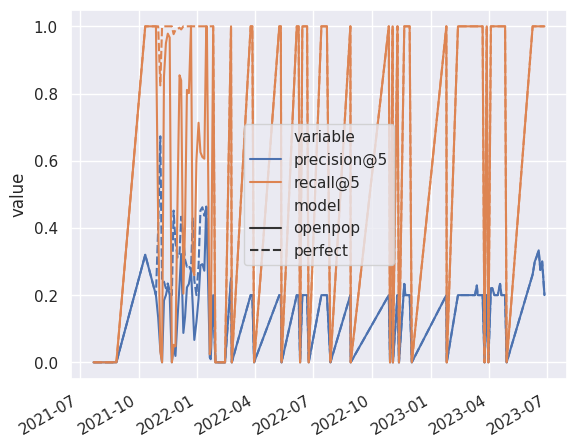

In [31]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [32]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2021-07-22 17:19:59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
1,2021-07-22 17:19:59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
2,2021-07-22 17:19:59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
3,2021-07-22 17:19:59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
4,2021-07-22 17:19:59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2023-06-14 02:56:44,0.312500,1.0,1.0,1.0,0.156250,1.0,1.0,1.0,0.104167,1.0,1.0,1.0,perfect
231,2023-06-17 15:18:40,0.333333,1.0,1.0,1.0,0.166667,1.0,1.0,1.0,0.111111,1.0,1.0,1.0,perfect
232,2023-06-20 05:01:26,0.275000,1.0,1.0,1.0,0.137500,1.0,1.0,1.0,0.091667,1.0,1.0,1.0,perfect
233,2023-06-23 01:45:24,0.300000,1.0,1.0,1.0,0.150000,1.0,1.0,1.0,0.100000,1.0,1.0,1.0,perfect


Cannot show ipywidgets in text

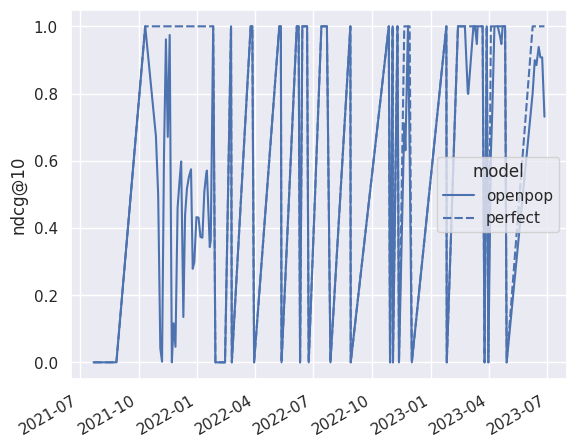

In [33]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [34]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.328358,1.0,0.993248,0.993248,0.168657,1.0,1.0,1.0,0.112438,1.0,1.0,1.0
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0
5,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
7,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0
9,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,0.100318,0.391489,0.390493,0.390493,0.050864,0.391489,0.391136,0.391136,0.034084,0.391489,0.391221,0.391221
std,0.136820,0.489125,0.488017,0.488017,0.071482,0.489125,0.488705,0.488705,0.048563,0.489125,0.488805,0.488805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000
max,0.672727,1.000000,1.000000,1.000000,0.463636,1.000000,1.000000,1.000000,0.339394,1.000000,1.000000,1.000000


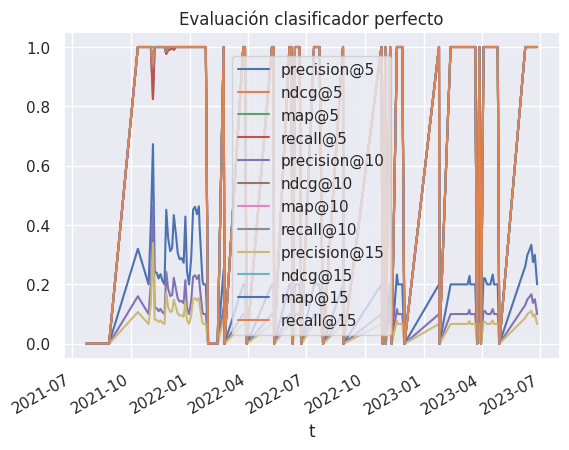

In [35]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [36]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 235 folds
From 2021-07-22 11:44:39 to 2023-07-01 00:51:20


,train,test,open,test users,test vpv,test vpp
count,235.000000,235.000000,235.000000,235.000000,98.000000,98.000000
mean,3046.680851,12.472340,6.612766,8.008511,0.832194,6.766663
std,1305.881948,31.586577,22.705450,19.747983,0.215302,6.066826
min,13.000000,0.000000,0.000000,0.000000,0.196078,0.298507
25%,3318.000000,0.000000,0.000000,0.000000,0.666667,3.000000
50%,3598.000000,0.000000,0.000000,0.000000,1.000000,4.750000
75%,3773.000000,8.500000,2.000000,7.500000,1.000000,8.312500
max,4095.000000,249.000000,167.000000,202.000000,1.000000,31.000000


In [37]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2021-07-25,13,0,1,0,NaN,NaN,NaT,NaT
1,2021-07-28,13,0,1,0,NaN,NaN,NaT,NaT
2,2021-07-31,13,0,1,0,NaN,NaN,NaT,NaT
3,2021-08-03,13,0,0,0,NaN,NaN,NaT,NaT
4,2021-08-06,13,0,0,0,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...
230,2023-06-15,4054,25,3,16,0.640000,5.333333,2023-06-15 02:31:21,2023-06-26 01:40:04
231,2023-06-18,4059,20,3,12,0.600000,4.000000,2023-06-18 01:15:40,2023-06-26 01:40:04
232,2023-06-21,4068,11,2,8,0.727273,4.000000,2023-06-21 22:09:04,2023-06-26 01:40:04
233,2023-06-24,4073,6,2,4,0.666667,2.000000,2023-06-24 17:17:05,2023-06-26 01:40:04


In [38]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 20 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window
44,2021-12-04,2815,67,33,42,0.626866,3.818182,2021-12-04 02:45:46,2021-12-21 12:20:12,True,True
45,2021-12-07,2841,41,30,19,0.463415,1.900000,2021-12-07 02:52:35,2021-12-21 12:20:12,True,True
46,2021-12-10,2915,168,34,82,0.488095,8.200000,2021-12-10 00:19:06,2022-01-10 02:34:39,True,True
47,2021-12-13,2955,128,31,65,0.507812,13.000000,2021-12-13 17:31:20,2022-01-10 02:34:39,True,True
48,2021-12-16,2975,108,31,55,0.509259,11.000000,2021-12-16 02:46:26,2022-01-10 02:34:39,True,True
49,2021-12-19,2996,87,31,40,0.459770,8.000000,2021-12-19 02:02:09,2022-01-10 02:34:39,True,True
50,2021-12-22,3007,76,30,33,0.434211,8.250000,2021-12-22 04:55:59,2022-01-10 02:34:39,True,True
51,2021-12-25,3080,109,32,40,0.366972,6.666667,2021-12-25 03:48:34,2022-01-10 08:44:57,True,True
52,2021-12-28,3115,107,33,39,0.364486,5.571429,2021-12-29 08:49:10,2022-01-10 08:44:57,True,True
53,2021-12-31,3228,23,31,21,0.913043,4.200000,2021-12-31 00:34:17,2022-01-10 08:44:57,True,True


In [39]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 19 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window
45,2021-12-07,2841,41,30,19,0.463415,1.900000,2021-12-07 02:52:35,2021-12-21 12:20:12,True,True,True,True
46,2021-12-10,2915,168,34,82,0.488095,8.200000,2021-12-10 00:19:06,2022-01-10 02:34:39,True,True,True,True
47,2021-12-13,2955,128,31,65,0.507812,13.000000,2021-12-13 17:31:20,2022-01-10 02:34:39,True,True,True,True
48,2021-12-16,2975,108,31,55,0.509259,11.000000,2021-12-16 02:46:26,2022-01-10 02:34:39,True,True,True,True
49,2021-12-19,2996,87,31,40,0.459770,8.000000,2021-12-19 02:02:09,2022-01-10 02:34:39,True,True,True,True
50,2021-12-22,3007,76,30,33,0.434211,8.250000,2021-12-22 04:55:59,2022-01-10 02:34:39,True,True,True,True
51,2021-12-25,3080,109,32,40,0.366972,6.666667,2021-12-25 03:48:34,2022-01-10 08:44:57,True,True,True,True
52,2021-12-28,3115,107,33,39,0.364486,5.571429,2021-12-29 08:49:10,2022-01-10 08:44:57,True,True,True,True
53,2021-12-31,3228,23,31,21,0.913043,4.200000,2021-12-31 00:34:17,2022-01-10 08:44:57,True,True,True,True


            train  test  i
t                         
2021-07-25     13     0  0
2021-07-28     13     0  1
2021-07-31     13     0  2
2021-08-03     13     0  3
2021-08-06     13     0  4
2021-08-09     13     0  5
2021-08-12     65     1  6
2021-08-15     75     1  7
2021-08-18     75     1  8
2021-08-21     76     0  9


Cannot show ipywidgets in text

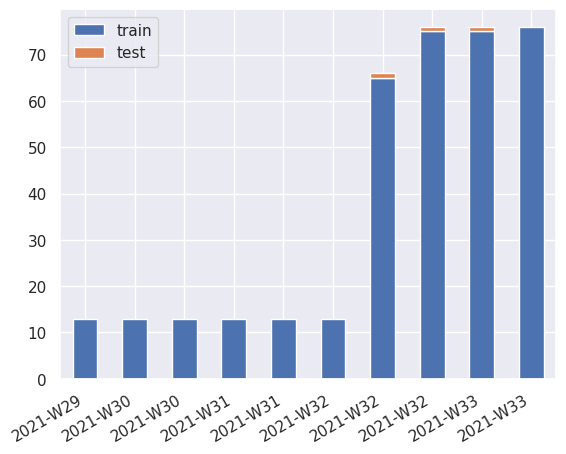

In [40]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

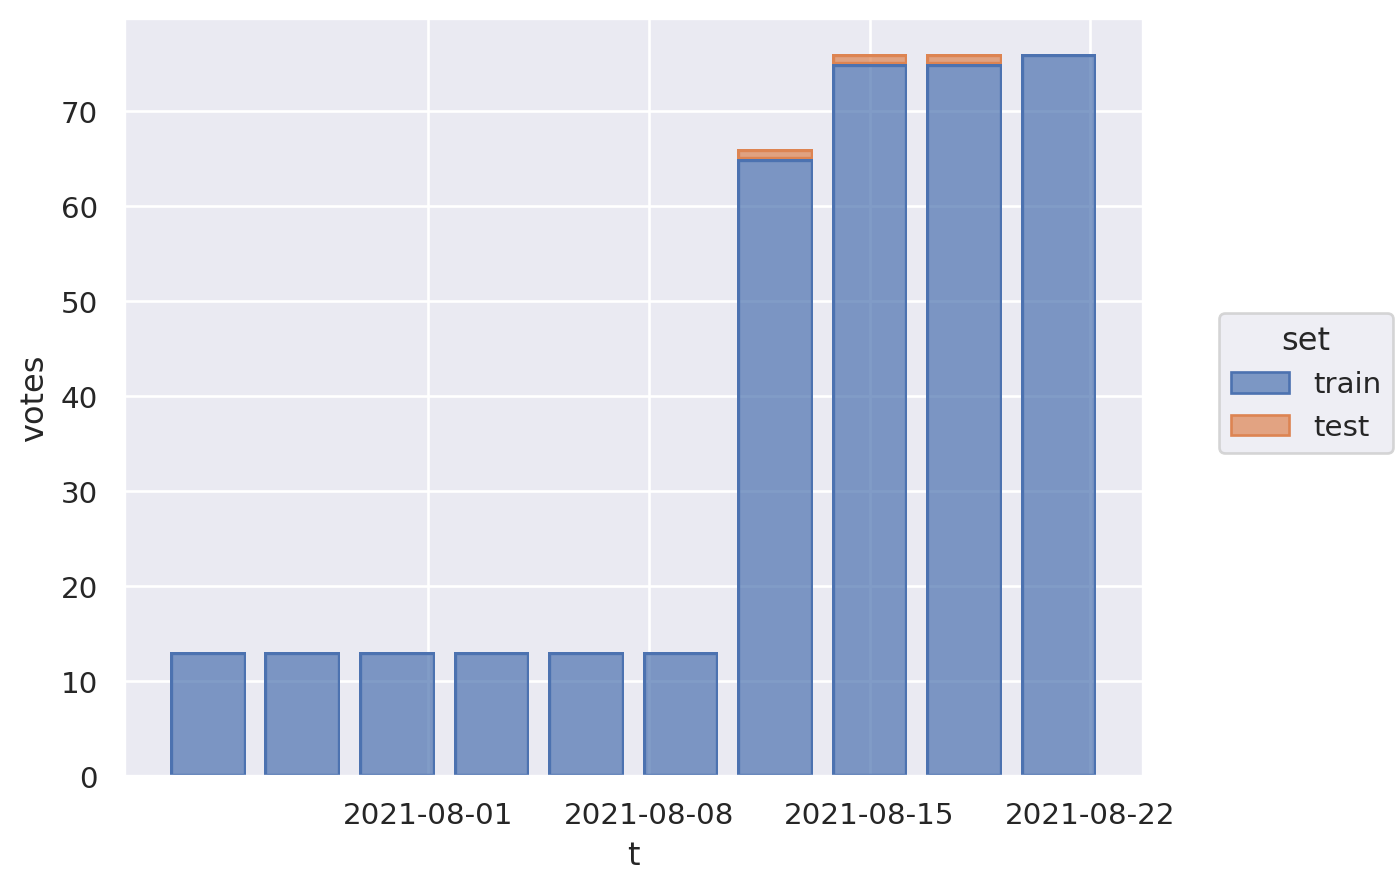

In [41]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())